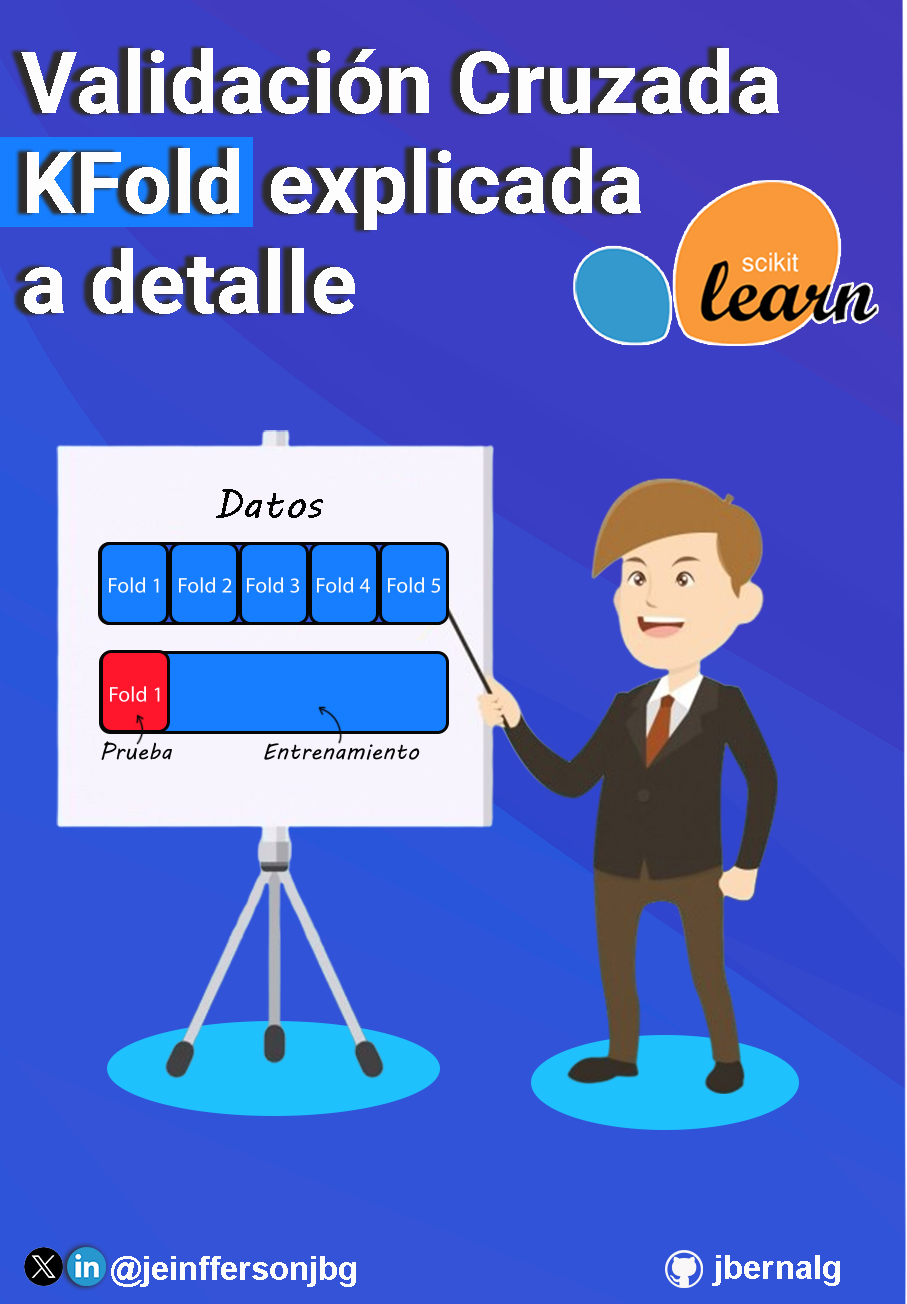

# Validación Cruzada K-Fold

Es una técnica robusta para evaluar el rendimiento de un modelo de Machine Learning y evitar problemas como el sobreajuste (*overfitting*). El proceso general de este método es el siguiente:

1.- **Dividir de los datos**: El conjunto de datos se divide en $K$ subconjuntos aproximadamente del mismo tamaño. A estos se les conoce como "*Fold*" o pliegues.

2.- **Iterar a través de los Folds**: Se realizan $K$ iteraciones de entrenamiento y prueba. En cada iteración, unos de los K folds se utiliza como conjunto de prueba y los otros $K-1$ folds como conjunto de entrenamiento. Esto implica que cada observación se utiliza exactamente una vez como conjunto de prueba y $K-1$ veces como parte del conjunto de entrenamiento.

3.- **Evaluar el modelo**: Se obtienen las métricas del modelo para cada iteración de los folds. 

4.- **Promediar resultados**: Después de las $K$ iteraciones, se promedian las métricas de rendimiento (como precisión, MSE, R-cuadrado, entre otros) para obtener una estimación más confiable del rendimiento del modelo.

## Ventajas y Desventajas

- Al utilizar todos los datos tanto para entrenamiento como para prueba, se obtiene una mejor estimación del rendimiento del modelo.

- Al promediar los resultados de las iteraciones, se reduce la varianza asociada con cualquier partición de los datos.

- A diferencia de la validación Hold Out, se utilizan todos los datos disponibles tanto para entrenamiento como para prueba.

- Su principal desventaja es que requiere entrenar el modelo $K$ veces lo que implica un alto costo computacional especialmente para modelos complejos y grandes conjuntos de datos.

## Implementación Manual

Vamos a implementar la Validacion Cruzada K-Fold de forma manual para entender paso a paso, en qué consiste este método. Para iniciar, creamos un conjunto de datos aleatorio a los cuales aplicarémos la validación. 

In [1]:
# librerias de manejo de datos
import numpy as np
import pandas as pd

# semilla aleatoria
np.random.seed(42)

# 3 Variables predictoras
X = pd.DataFrame({
    'var_1': np.random.rand(100),
    'var_2': np.random.rand(100),
    'var_3': np.random.rand(100),
})

# Variable objetivo
y = 3*X['var_1'] + 2*X['var_3'] + np.random.randn(100)

# y convertida en Serie
df_y = pd.Series(y, name='y')

# concatenamos la variable objetivo con las predictoras
df = pd.concat([X, df_y], axis=1)

# mostrar datos creados
df


,var_1,var_2,var_3,y
0,0.374540,0.031429,0.642032,2.453255
1,0.950714,0.636410,0.084140,2.368823
2,0.731994,0.314356,0.161629,4.663183
3,0.598658,0.508571,0.898554,4.227003
4,0.156019,0.907566,0.606429,-0.344229
...,...,...,...,...
95,0.493796,0.349210,0.522243,3.317536
96,0.522733,0.725956,0.769994,3.732305
97,0.427541,0.897110,0.215821,2.342611
98,0.025419,0.887086,0.622890,1.309792


Se han creado 100 observaciones con datos aleatorios para 3 variables predictoras y una objetivo. Decidimos que la variable 'y' presente una relación lineal con las variables var_1 y var_3 para tener certeza sobre el comportamiento de los datos.

###  **1.- Dividir los datos**

Definimos el número de folds que popularmente se toma $K=5$ o $K=10$ y calculamos el tamaño de cada fold dividiendo el número total de observaciones entre $K$.

In [2]:
# numero de folds
K = 5
# numero total de muestras (100 en este caso)
n_muestras = len(X)
# tamano de los folds
size_fold = n_muestras // K
# mostrar tamano de los folds
size_fold

20

Tenemos 5 folds de 20 observaciones cada uno. Ahora, mezclamos los índices de las observaciones aleatoriamente para asegurar que la división de los folds sea aleatoria.

In [3]:
# mezcla aleatoria de los indices
mix_index = np.random.permutation(n_muestras)
# reordenar valores de X con indices mezclados
X_mix = X.iloc[mix_index]
# reordenar valores de y con indices mezclados
y_mix = y.iloc[mix_index]
# mostrar Variables predicotras mezcladas
X_mix

,var_1,var_2,var_3
47,0.520068,0.502679,0.966655
22,0.292145,0.318003,0.093675
23,0.366362,0.110052,0.367716
58,0.045227,0.237638,0.570061
85,0.325183,0.659984,0.035942
...,...,...,...
34,0.965632,0.942910,0.195243
4,0.156019,0.907566,0.606429
94,0.770967,0.339030,0.127061
13,0.212339,0.808120,0.224269


Una vez mezclada las observaciones, inicializamos las listas que almacenarán las métricas del modelo. Utilizarémos un modelo de Regresión Lineal por lo que las métricas a evaluar son $R^2$ y $MSE$. Debemos crear un par de listas para las métricas del conjunto entrenamiento y otro par para el conjunto de prueba en cada fold.

In [4]:
# librerias para usar el modelo y las metricas
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# listas para metricas de entrenamiento
train_r2 = []
train_mse = []

# listas para metricas de prueba
test_r2 = []
test_mse = []

### **2 y 3.- Iterar sobre cada fold y entrenar el modelo K veces**

Con un bucle, iteramos sobre cada fold con el que se entrena el modelo y se calcula las métricas tanto para el conjunto de entrenamiento como de prueba.

In [5]:
for k in range(K):
    # indice inicial fold actual
    ini = k*size_fold
    # indice final fold actual
    fin = (k+1)*size_fold
    
    #asignar observaciones al conjunto de prueba
    X_test = X_mix.iloc[ini:fin]
    y_test = y_mix.iloc[ini:fin]
    # asignar las observaciones restantes al conjunto de entrenamiento
    X_train = pd.concat([X_mix.iloc[:ini], X_mix.iloc[fin:]])
    y_train = pd.concat([y_mix.iloc[:ini], y_mix.iloc[fin:]])
    
    # instanciar y entrenar el modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # predicciones con datos de entrenamiento
    y_train_pred = model.predict(X_train)
    # predicciones con datos de prueba
    y_test_pred = model.predict(X_test)
    
    # calculo de metricas de entrenamiento
    train_r2.append(r2_score(y_train, y_train_pred))
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    
    # calculo de metricas de prueba
    test_r2.append(r2_score(y_test, y_test_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    

### **4.- Promediar resultados**

Se promedian las métricas para los conjuntos de entrenamiento y prueba a lo largo de todos los folds.

In [6]:
print(f'Promedio de R-cuadrado para datos de entrenamiento: {round(np.mean(train_r2),4)}')
print(f'Promedio de R-cuadrado para datos de prueba: {round(np.mean(test_r2),4)}')
print(f'Promedio de MSE para datos de entrenamiento: {round(np.mean(train_mse),4)}')
print(f'Promedio de MSE para datos de prueba: {round(np.mean(test_mse),4)}')

Promedio de R-cuadrado para datos de entrenamiento: 0.6082
Promedio de R-cuadrado para datos de prueba: 0.5314
Promedio de MSE para datos de entrenamiento: 0.9168
Promedio de MSE para datos de prueba: 1.0338


> La diferencia entre el R² y el MSE en los conjuntos de entrenamiento y prueba sugiere que el modelo puede estar sobreajustado. Está capturando bien la variabilidad en los datos de entrenamiento, pero su capacidad para generalizar a datos nuevos es algo limitada.

> El sobreajuste ocurre cuando un modelo se ajusta demasiado bien a los datos de entrenamiento y no generaliza bien a nuevos datos. En este caso, el R² es más alto y el MSE es más bajo en el conjunto de entrenamiento en comparación con el conjunto de prueba.

> A pesar de estas diferencias, este método captura mucho mejor el rendimiento del modelo y evita el sesgo de los datos. 

## Implementación con Scikit Learn

La implementación de esta método con Scikit Learn nos permite reducir líneas de código pero el procedimiento es el mismo. Vamos a trabajar sobre los datos de prueba anteriores: $X$ e $y$.

In [8]:
# dataframe con las variables de X e y
df

,var_1,var_2,var_3,y
0,0.374540,0.031429,0.642032,2.453255
1,0.950714,0.636410,0.084140,2.368823
2,0.731994,0.314356,0.161629,4.663183
3,0.598658,0.508571,0.898554,4.227003
4,0.156019,0.907566,0.606429,-0.344229
...,...,...,...,...
95,0.493796,0.349210,0.522243,3.317536
96,0.522733,0.725956,0.769994,3.732305
97,0.427541,0.897110,0.215821,2.342611
98,0.025419,0.887086,0.622890,1.309792


### **1.- Dividir los datos**

importamos el método KFold, lo configuramos con las cantidad de pliegues requeridos, una semilla aleatoria y con mezclado de los datos para asegurar aleatoriedad en la elección de los pliegues.

In [13]:
# libreria para utilizar KFold
from sklearn.model_selection import KFold

# Configuracion KFold
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

Ahora, procedemos a crear el par de listas que almacenarán las métricas obtenidas por el modelo entrenado con los datos de entrenamiento y otro par para las métricas obtenidas al evaluar el modelo con los datos de prueba.

In [10]:
# listas para metricas de entrenamiento
train_r2 = []
train_mse = []

# listas para metricas de prueba
test_r2 = []
test_mse = []

### **2 y 3.- Iterar sobre cada fold y entrenar el modelo K veces**

- Se itera sobre los pliegues (Folds) generados por Kf. 

- Kf devuelve índices de entrenamiento y prueba para cada pliegue. 

- Para cada pliegue, se divide los datos de $X$ e $y$ en conjuntos de entrenamiento y prueba usando los índices generados.

- Se entrena el modelo y se obtienen las prediccions para luego calcular las métricas tanto de los datos de entrenamiento como de prueba.

In [14]:
# iterar sobre los indices de cada pliegue
for train_index, test_index in kf.split(X):
    # datos de entrenamiento y prueba para el pliegue actual
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # instanciar y entrenar el modelo
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    
    # predicciones con datos de entrenamiento
    y_train_pred = modelo.predict(X_train)
    # predicciones con datos de prueba
    y_test_pred = modelo.predict(X_test)
    
    # calculo de metricas de entrenamiento
    train_r2.append(r2_score(y_train, y_train_pred))
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    
    # calculo de metricas de prueba
    test_r2.append(r2_score(y_test, y_test_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    

### **4.- Promediar resultados**

In [15]:
print(f'Promedio de R-cuadrado para datos de entrenamiento: {round(np.mean(train_r2),4)}')
print(f'Promedio de R-cuadrado para datos de prueba: {round(np.mean(test_r2),4)}')
print(f'Promedio de MSE para datos de entrenamiento: {round(np.mean(train_mse),4)}')
print(f'Promedio de MSE para datos de prueba: {round(np.mean(test_mse),4)}')

Promedio de R-cuadrado para datos de entrenamiento: 0.6113
Promedio de R-cuadrado para datos de prueba: 0.5357
Promedio de MSE para datos de entrenamiento: 0.9131
Promedio de MSE para datos de prueba: 1.0662


> Obtenemos los mismo resultados que al aplicarlo de forma manual. KFold de Scikit Learn mezcla los datos y selecciona los índices de cada pliegue, por tanto en este caso, arroja 5 pares de índices (inicial y final) debido a que fueron seleccionados 5 folds.

> Al promediar los resultados, se obtiene una estimación más robusta y menos sesgada. Además, esta técnica utiliza todos los datos tanto para entrenamiento como para prueba lo que le da ventaja sobre otras técnicas.